### Schulung Machine Learning Libraries -Tensorflow mit Keras

##### Ausgangsinformation: Bitte immer die Kommentare IM Code durch den tatsächlichen Code ersetzen. An manchen Stellen dürfen keine Kommentare (z.B. #Eure Ergänzungen) mehr beim Ausführen im Code stehen!

**0.** Ladet euch die Winrar-Datei "Bilder" aus Moodle herunter und entpackt diese. Speichert den entpackten Ordner in dasselbe Verzeichnis, indem auch euer Notebook liegt (falls möglich).

**1.** Zunächst müssen wir die benötigten Module importieren und TensorFlow per !pip install installieren

In [ ]:
!pip install tensorflow --upgrade

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os

import matplotlib.pyplot as plt

**2.** Nun wollen wir uns zur Übersicht die enthaltenen Unterordner von dem Ordner "Bilder" ausgeben lassen. Dies lässt sich mit dem Befehl `ls "Ordnername"` durchführen.


In [2]:
ls "Bilder"

Hund/  Katze/


Jetzt müssten in der Ausgabe die beiden Unterordner "Hund" und "Katze" zu sehen sein.

**3.** Bevor mit den Bildern gearbeitet werden kann, ist es ratsam, alle schlecht kodierten Bilder zu entfernen. Dafür sortieren wir alle Bilder aus, welche nicht dem JFIF (JPG/JPEG) Format entsprechen. Dies trifft bei unseren Datensätzen nicht zu.

In [3]:
num_skipped = 0
for ordner_name in ("Hund", "Katze"):
    ordner_pfad = os.path.join("Bilder", ordner_name)
    for oname in os.listdir(ordner_pfad):
        opfad = os.path.join(ordner_pfad, oname)
        try:
            oobj = open(opfad, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in oobj.peek(10)
        except:
            print("Nicht uterstützt")
        finally:
            oobj.close()

        if not is_jfif:
            num_skipped += 1
            os.remove(opfad)

print("Gelöschte Bilder: %d" % num_skipped)

Nicht uterstützt
Nicht uterstützt
Gelöschte Bilder: 0


**4.** Als nächsten Schritt wollen wir die Bilder in ein Dataset einlesen. 
Vorher müssen wir aber noch die Bilder in eine einheitliche Größe bringen. Wir wollen hier eine Größe von 180x180 festlegen `image_size = (Größe, Größe)`. Außerdem wollen wir die Bilder für das Modell in mehrere Batches aufteilen (`batch_size = Anzahl Batches`). Hier wählen wir 16 Batches aus. Zudem wollen wir einen `validation_split` von 0.2 bei den Trainings- und Validierungsdaten.

In [4]:
#einheitliche Größe festlegen
image_size = (180, 180)
#Größe der Batches festlegen
batch_size = 16

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Bilder",
    validation_split=0.2,
    subset="training",
    seed=9,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Bilder",
    validation_split=0.2,
    subset="validation",
    seed=9,
    image_size=image_size,
    batch_size=batch_size,
)

Found 202 files belonging to 3 classes.
Using 162 files for training.
Found 202 files belonging to 3 classes.
Using 40 files for validation.


**5.** Nun können wir einen kleinen Blick in die eingelesenen Trainingsdaten werfen. Ihr werdet feststellen, dass die Hundebilder mit `0` und die Katzenbilder mit `1` gekennzeichnet wurden.

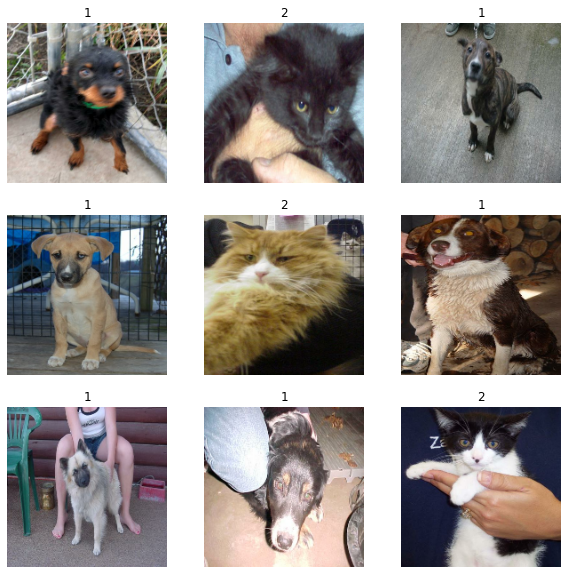

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

**6.** Da wir in dieser Schulung mit einem sehr kleinen Dataset arbeiten, kann es zu Ungenauigkeiten bei den späteren Vorhersagen unseres Modells kommen. Um dem etwas entgegen zu  wirken führen wir eine Image Data Augmentation durch. Diese Funktion erstellt später aus unseren Input-Bildern durch Kippen (`layers.RandomRotation(0.1)`) und horizontales Spiegeln (`layers.RandomFlip("horizontal")`) neue Bilder für den Trainigsprozess.

In [6]:
data_augmentation = keras.Sequential(
    [layers.RandomRotation(0.1), layers.RandomFlip("horizontal")]
)

**7.** Im Folgenden Code-Segment könnt ihr euch die Funktionsweise von `data_augmentation` beispielhaft für ein zufälliges Bild anzeigen lassen. Beachtet die minimalen Drehungen.

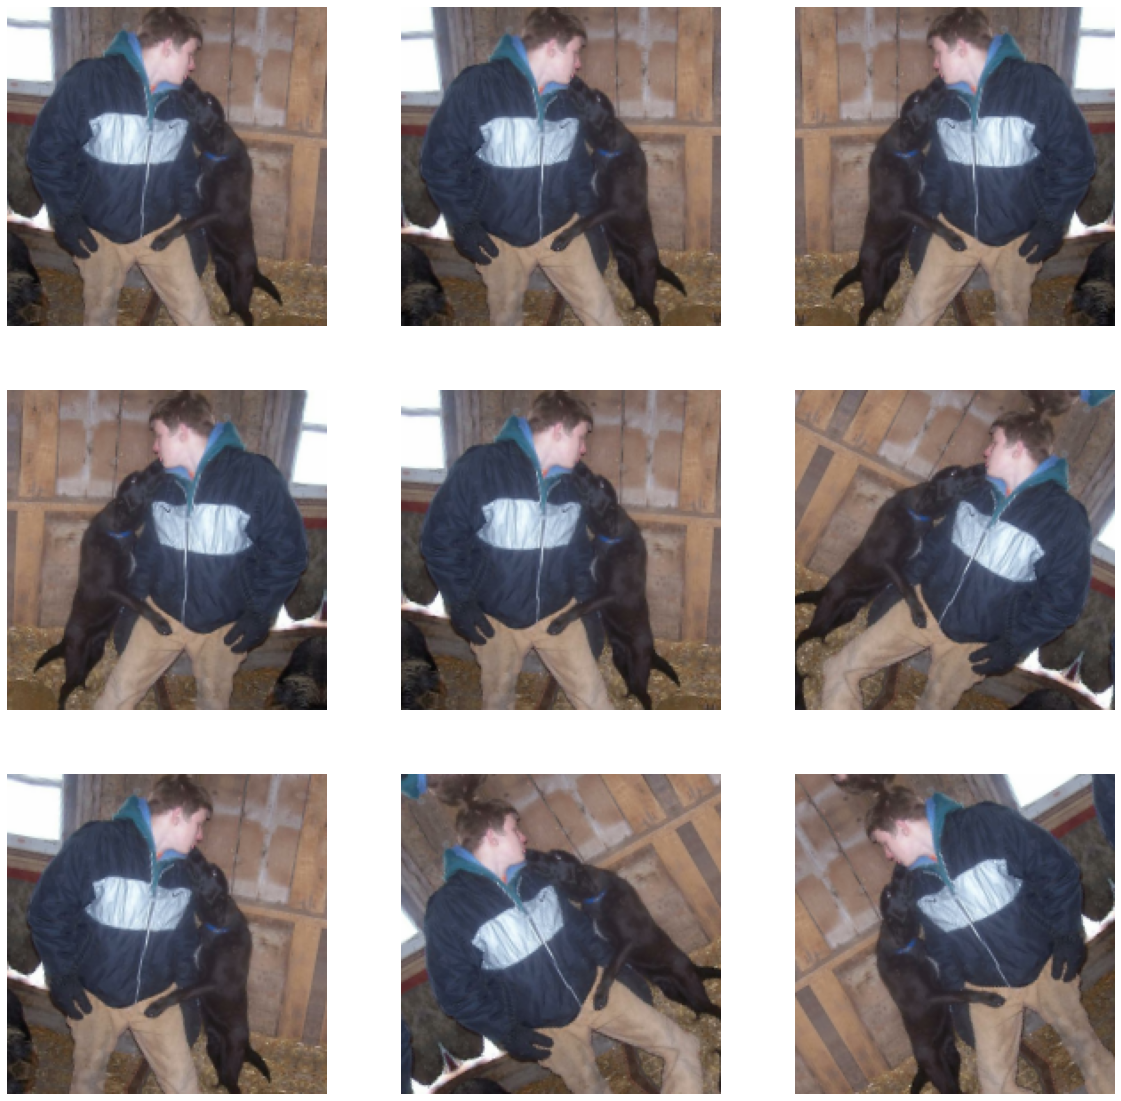

In [7]:
plt.figure(figsize=(20,20))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


**8.** Als nächsten Schritt werden die Datensätze für eine bessere Performance angepasst. Dafür wird die Zeit, in der die Daten produziert werden, von der Zeit, in der die Daten weiterverarbeitet werden, entkoppelt. Dadurch wird das Risiko von Eingabe- und Ausgabefehlern reduziert. Dafür ergänzen wir die beiden Befehle jeweils um `prefetch(buffer_size=16)`.

In [9]:
train_ds = train_ds.prefetch(buffer_size=16)
val_ds = val_ds.prefetch(buffer_size=16)

**9.** Nun können wir mit dem Bauen des Modells anfangen. Dort wird zunächst ein Keras-Tensor instanziiert (`inputs = keras.Input(shape=input_shape)`). Anschließend übergeben wir der Variablen x unsere data_augmentation (`x = data_augmentation(inputs)`). Danach müssen wir die Daten noch normalisieren (zwischen 0 und 1). Da unsere Farben RGB aufweisen (und daher eine Pixelweite von 0-255 besitzen), müssen wir diese mit 255 dividieren, um in den gewünschten Wertebreich zu gelangen (`x = layers.Rescaling(1.0 / 255)(x)`). Unser Modell basiert auf der funktionellen API von Keras. Deswegen wird `x` beginnend vom `Rescaling` Layer immer von Layer zu Layer weiter gegeben.

In [10]:
def make_model(input_shape, num_classes):
    #Keras-Tensor instanziieren 
    inputs = keras.Input(shape=input_shape)
    #Data Augmentation an x übergeben
    x = data_augmentation(inputs)
    
    #RGB zu gewünschten Wertebereich normalisieren
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

       
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  
        previous_block_activation = x  

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)

**10.** Nachdem wir das Modell erfolgreich erstellt haben, können wir dieses trainieren. Epochs definieren, wie häufig der Trainingsprozess durchlaufen werden soll. Wir setzen diesen Wert auf 5 (`epochs = Anzahl Trainingsdurchläufe`). Callbacks können genutzt werden, um verschiedene Aktionen in verschiedenen Trainingsschritten durchzuführen. Wir nutzen diese Möglichkeit und erstellen einen `ModelCheckpoint`. Dieser kann das Modell oder verschiedene Gewichtungen speichern, damit bspw. eine spätere Weiterarbeit an demselben Punkt ermöglicht wird.

Danach wird das Modell noch kompiliert. Als optimizer wollen wir Adam mit einer Learnrate von 0.01 nutzen (`optimizer=keras.optimizers.Adam(0.01)`).
Zum Schluss müssen wir dieses Modell nur noch trainieren `model.fit()`. Als Parameter übergeben wir `train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds`.

**Achtung:** Es könnte je nach Rechenleistung zu erhöhten Ausführungszeiten kommen. Wenn ihr ungeduldig werdet, könnt ihr vielleicht schon mal mit dem Quiz beginnen. 

Zudem wird eine Warnung ausgegeben, welche aber ignoriert werden kann.

In [ ]:
#Anzahl der Epochs definieren
epochs = 5
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    #optimizer mit adam angeben
    optimizer=keras.optimizers.Adam(0.01),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds
)


Epoch 1/5
11/11 [==============================] - ETA: 0s - loss: -8.6526 - accuracy: 0.4877

/opt/conda/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


11/11 [==============================] - 41s 3s/step - loss: -8.6526 - accuracy: 0.4877 - val_loss: -235.3365 - val_accuracy: 0.4250
Epoch 2/5
 5/11 [============>.................] - ETA: 13s - loss: -35.3708 - accuracy: 0.4250

Was könnten Gründe für die geringe `val_accuracy` sein? 

**11.** Dieses trainierte Modell könnten wir nun theoretisch mit neuen Daten testen und schauen, ob das Modell das angegebene Bild als Hund bzw. Katze richtig identifiziert. Da unser Trainingsdatenset nur sehr klein war, wird die Ausgabe hier sehr ungenau sein. Deshalb beachten wir diese nicht weiter. Falls ihr die Schulung nochmal mit dem kompletten Datensatz von Kaggle durchführen wollt, könnt ihr am Ende gerne diese Prediction-Methode anwenden.

In [1]:
img = keras.preprocessing.image.load_img(
    "bild.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

NameError: name 'keras' is not defined

## Nun wechselt bitte in das nächste Notebook (Scikit-Learn-Schulung)
#### Datensatz (angepasst) von: https://www.kaggle.com/shaunthesheep/microsoft-catsvsdogs-dataset